In [38]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from numba import jit
import plotly_express as px
from itertools import combinations
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
os.chdir('C:\Finance_projects\Optiver-Realized-Volatility-Prediction\data')

## all unique stock ids in book data
# same stocks are also in trade data 
subset_paths = glob.glob('book_train.parquet/stock_id=*')
unique_stocks_id = []
for path in subset_paths:
    unique_stocks_id.append(int(path.split('=')[1]))

unique_stocks_id = np.sort(np.array(unique_stocks_id))
print('total # stocks: ',len(unique_stocks_id))
unique_stocks_id

train = pd.read_csv('c:/Finance_projects/Optiver-Realized-Volatility-Prediction/data/train.csv')

total # stocks:  112


In [ ]:
## SET PARAMETERS HERE for book_train.parquet files ONLY!!
## set the level (1 or 2) of the book data to use and Correlation method

level = 1 # set level 1 or 2 for book_train data
corr_method = 'pearson' # set 'pearson' or 'spearman'
file = 'book_train'


bid_price = "bid_price"+str(level)
ask_price = "ask_price"+str(level)
bid_size = "bid_size"+str(level)
ask_size = "ask_size"+str(level)

In [225]:
## give a dataframe with two columns to plot scatter and return correlation coefficient, x axis is column 1 and y axis is column 2
def plot_scatter_n_correlation(df,st_id,method='pearson'):
    corr = df.corr(method=method)
    corr_coef = corr[corr.columns[0]][1] # convert from matrix to single number
    fig = px.scatter(df,x=df.columns[0],y=df.columns[1])
    fig.update_traces(textposition='top center')

    fig.update_layout(
        height=400,width=700,
        title_text='scatter plot, stock id: '+str(st_id)+ '. Correlation coef: '+ str(corr_coef) + ' method: '+method,
    )
    #fig.show()  # enable/disable plot

    return corr_coef

In [ ]:
def my_func(bid_size, bid_price):
    return bid_size.corr(bid_price)

In [232]:
def my_range_price(series):
    return series.max()-series.min()

In [228]:
def my_sum_abs_diff(series):
    return np.sum(np.abs(series.diff()))

In [229]:
columns = [bid_size,bid_price,ask_size,ask_price]

def all_pairs_of_columns_list(columns):
    return list(combinations(columns, 2))



In [230]:
## 7a) - 7e) Check if minimum/maximum/range of bidsize1/bid_price1 and asksize1/ask_price1 in a time_id correlated with target realized volatitlity for the same time_id?

train_target = pd.read_csv('train.csv')

subset_paths = glob.glob(file+'.parquet/stock_id=*')

min_bid_price_n_target_vol_corr_coef = {}
max_bid_price_n_target_vol_corr_coef = {}
min_ask_price_n_target_vol_corr_coef = {}
max_ask_price_n_target_vol_corr_coef = {}
min_bid_size_n_target_vol_corr_coef = {}
max_bid_size_n_target_vol_corr_coef = {}
min_ask_size_n_target_vol_corr_coef = {}
max_ask_size_n_target_vol_corr_coef = {}
range_ask_price_n_target_vol_corr_coef = {}
range_bid_price_n_target_vol_corr_coef = {}
range_ask_size_n_target_vol_corr_coef = {}
range_bid_size_n_target_vol_corr_coef = {}

for path in subset_paths:
    st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        book_train_st = pd.read_parquet(path)

        st_min_max_bid_price = book_train_st.groupby(by='time_id')[bid_price].agg(['min','max']).rename(columns={'min':'min_bid_price','max':'max_bid_price'})
        common_time_id_mmbp = np.intersect1d(st_min_max_bid_price.index.values, target_st['time_id'].values) # ensure that only common time ids in trade_train and target are used.
        min_bid_price_n_target_vol_df = pd.DataFrame({'min_bid_price':st_min_max_bid_price.loc[common_time_id_mmbp,"min_bid_price"].values , 'target_vol':target_st.loc[common_time_id_mmbp,"target"].values})
        corr_coef_min_bid_price = plot_scatter_n_correlation(min_bid_price_n_target_vol_df,st_id,method=corr_method)
        min_bid_price_n_target_vol_corr_coef[st_id] = corr_coef_min_bid_price
        max_bid_price_n_target_vol_df = pd.DataFrame({'max_bid_price':st_min_max_bid_price.loc[common_time_id_mmbp,"max_bid_price"].values , 'target_vol':target_st.loc[common_time_id_mmbp,"target"].values})
        corr_coef_max_bid_price = plot_scatter_n_correlation(max_bid_price_n_target_vol_df,st_id,method=corr_method)
        max_bid_price_n_target_vol_corr_coef[st_id] = corr_coef_max_bid_price         

        st_min_max_ask_price = book_train_st.groupby(by='time_id')[ask_price].agg(['min','max']).rename(columns={'min':'min_ask_price','max':'max_ask_price'})
        common_time_id_mmap = np.intersect1d(st_min_max_ask_price.index.values, target_st['time_id'].values)
        min_ask_price_n_target_vol_df = pd.DataFrame({'min_ask_price':st_min_max_ask_price.loc[common_time_id_mmap,"min_ask_price"].values , 'target_vol':target_st.loc[common_time_id_mmap,"target"].values})
        corr_coef_min_ask_price = plot_scatter_n_correlation(min_ask_price_n_target_vol_df,st_id,method=corr_method)
        min_ask_price_n_target_vol_corr_coef[st_id] = corr_coef_min_ask_price
        max_ask_price_n_target_vol_df = pd.DataFrame({'max_ask_price':st_min_max_ask_price.loc[common_time_id_mmap,"max_ask_price"].values , 'target_vol':target_st.loc[common_time_id_mmap,"target"].values})
        corr_coef_max_ask_price = plot_scatter_n_correlation(max_ask_price_n_target_vol_df,st_id,method=corr_method)
        max_ask_price_n_target_vol_corr_coef[st_id] = corr_coef_max_ask_price

        st_min_max_bid_size = book_train_st.groupby(by='time_id')[bid_size].agg(['min','max']).rename(columns={'min':'min_bid_size','max':'max_bid_size'})
        common_time_id_mmbz = np.intersect1d(st_min_max_bid_size.index.values, target_st['time_id'].values)
        min_bid_size_n_target_vol_df = pd.DataFrame({'min_bid_size':st_min_max_bid_size.loc[common_time_id_mmbz,"min_bid_size"].values , 'target_vol':target_st.loc[common_time_id_mmbz,"target"].values})
        corr_coef_min_bid_size = plot_scatter_n_correlation(min_bid_size_n_target_vol_df,st_id,method=corr_method)
        min_bid_size_n_target_vol_corr_coef[st_id] = corr_coef_min_bid_size
        max_bid_size_n_target_vol_df = pd.DataFrame({'max_bid_size':st_min_max_bid_size.loc[common_time_id_mmbz,"max_bid_size"].values , 'target_vol':target_st.loc[common_time_id_mmbz,"target"].values})
        corr_coef_max_bid_size = plot_scatter_n_correlation(max_bid_size_n_target_vol_df,st_id,method=corr_method)
        max_bid_size_n_target_vol_corr_coef[st_id] = corr_coef_max_bid_size

        st_min_max_ask_size = book_train_st.groupby(by='time_id')[ask_size].agg(['min','max']).rename(columns={'min':'min_ask_size','max':'max_ask_size'})
        common_time_id_mmas = np.intersect1d(st_min_max_ask_size.index.values, target_st['time_id'].values)
        min_ask_size_n_target_vol_df = pd.DataFrame({'min_ask_size':st_min_max_ask_size.loc[common_time_id_mmas,"min_ask_size"].values , 'target_vol':target_st.loc[common_time_id_mmas,"target"].values})
        corr_coef_min_ask_size = plot_scatter_n_correlation(min_ask_size_n_target_vol_df,st_id,method=corr_method)
        min_ask_size_n_target_vol_corr_coef[st_id] = corr_coef_min_ask_size
        max_ask_size_n_target_vol_df = pd.DataFrame({'max_ask_size':st_min_max_ask_size.loc[common_time_id_mmas,"max_ask_size"].values , 'target_vol':target_st.loc[common_time_id_mmas,"target"].values})
        corr_coef_max_ask_size = plot_scatter_n_correlation(max_ask_size_n_target_vol_df,st_id,method=corr_method)
        max_ask_size_n_target_vol_corr_coef[st_id] = corr_coef_max_ask_size

        st_range_ask_price = book_train_st.groupby(by='time_id').agg({ask_price:[my_range_price]}).rename(columns={ask_price:'range_ask_price'})
        st_range_ask_price.columns = st_range_ask_price.columns.droplevel(1)
        common_time_id_rap = np.intersect1d(st_range_ask_price.index.values, target_st['time_id'].values)
        range_ask_price_n_target_vol_df = pd.DataFrame({'range_ask_price':st_range_ask_price.loc[common_time_id_rap,"range_ask_price"].values , 'target_vol':target_st.loc[common_time_id_rap,"target"].values})
        corr_coef_range_ask_price = plot_scatter_n_correlation(range_ask_price_n_target_vol_df,st_id,method=corr_method)
        range_ask_price_n_target_vol_corr_coef[st_id] = corr_coef_range_ask_price

        st_range_bid_price = book_train_st.groupby(by='time_id').agg({bid_price:[my_range_price]}).rename(columns={bid_price:'range_bid_price'})
        st_range_bid_price.columns = st_range_bid_price.columns.droplevel(1)
        common_time_id_rbp = np.intersect1d(st_range_bid_price.index.values, target_st['time_id'].values)
        range_bid_price_n_target_vol_df = pd.DataFrame({'range_bid_price':st_range_bid_price.loc[common_time_id_rbp,"range_bid_price"].values , 'target_vol':target_st.loc[common_time_id_rbp,"target"].values})
        corr_coef_range_bid_price = plot_scatter_n_correlation(range_bid_price_n_target_vol_df,st_id,method=corr_method)
        range_bid_price_n_target_vol_corr_coef[st_id] = corr_coef_range_bid_price

        st_range_ask_size = book_train_st.groupby(by='time_id').agg({ask_size:[my_range_price]}).rename(columns={ask_size:'range_ask_size'})
        st_range_ask_size.columns = st_range_ask_size.columns.droplevel(1)
        common_time_id_ras = np.intersect1d(st_range_ask_size.index.values, target_st['time_id'].values)
        range_ask_size_n_target_vol_df = pd.DataFrame({'range_ask_size':st_range_ask_size.loc[common_time_id_ras,"range_ask_size"].values , 'target_vol':target_st.loc[common_time_id_ras,"target"].values})
        corr_coef_range_ask_size = plot_scatter_n_correlation(range_ask_size_n_target_vol_df,st_id,method=corr_method)
        range_ask_size_n_target_vol_corr_coef[st_id] = corr_coef_range_ask_size

        st_range_bid_size = book_train_st.groupby(by='time_id').agg({bid_size:[my_range_price]}).rename(columns={bid_size:'range_bid_size'})
        st_range_bid_size.columns = st_range_bid_size.columns.droplevel(1)
        common_time_id_rbs = np.intersect1d(st_range_bid_size.index.values, target_st['time_id'].values)
        range_bid_size_n_target_vol_df = pd.DataFrame({'range_bid_size':st_range_bid_size.loc[common_time_id_rbs,"range_bid_size"].values , 'target_vol':target_st.loc[common_time_id_rbs,"target"].values})
        corr_coef_range_bid_size = plot_scatter_n_correlation(range_bid_size_n_target_vol_df,st_id,method=corr_method)
        range_bid_size_n_target_vol_corr_coef[st_id] = corr_coef_range_bid_size




KeyError: 'Column not found: bid_price1'

In [ ]:
## plot all stocks min_bid_price correlation vs. target 
coef_df=pd.DataFrame({'stock_id':min_bid_price_n_target_vol_corr_coef.keys(),'correlation_coef':min_bid_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(min_bid_price_n_target_vol_df.columns[0]) + " and " + str(min_bid_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks max_bid_price correlation vs. target 
coef_df=pd.DataFrame({'stock_id':max_bid_price_n_target_vol_corr_coef.keys(),'correlation_coef':max_bid_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(max_bid_price_n_target_vol_df.columns[0]) + " and " + str(max_bid_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()


## plot all stocks min_ask_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_ask_price_n_target_vol_corr_coef.keys(),'correlation_coef':min_ask_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(min_ask_price_n_target_vol_df.columns[0]) + " and " + str(min_ask_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks max_ask_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_ask_price_n_target_vol_corr_coef.keys(),'correlation_coef':max_ask_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(max_ask_price_n_target_vol_df.columns[0]) + " and " + str(max_ask_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks min_bid_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_bid_size_n_target_vol_corr_coef.keys(),'correlation_coef':min_bid_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(min_bid_size_n_target_vol_df.columns[0]) + " and " + str(min_bid_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks max_bid_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_bid_size_n_target_vol_corr_coef.keys(),'correlation_coef':max_bid_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(max_bid_size_n_target_vol_df.columns[0]) + " and " + str(max_bid_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks min_ask_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_ask_size_n_target_vol_corr_coef.keys(),'correlation_coef':min_ask_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(min_ask_size_n_target_vol_df.columns[0]) + " and " + str(min_ask_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks max_ask_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_ask_size_n_target_vol_corr_coef.keys(),'correlation_coef':max_ask_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(max_ask_size_n_target_vol_df.columns[0]) + " and " + str(max_ask_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks range_ask_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_ask_price_n_target_vol_corr_coef.keys(),'correlation_coef':range_ask_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(range_ask_price_n_target_vol_df.columns[0]) + " and " + str(range_ask_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks range_bid_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_bid_price_n_target_vol_corr_coef.keys(),'correlation_coef':range_bid_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(range_bid_price_n_target_vol_df.columns[0]) + " and " + str(range_bid_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks range_ask_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_ask_size_n_target_vol_corr_coef.keys(),'correlation_coef':range_ask_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(range_ask_size_n_target_vol_df.columns[0]) + " and " + str(range_ask_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks range_bid_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_bid_size_n_target_vol_corr_coef.keys(),'correlation_coef':range_bid_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(range_bid_size_n_target_vol_df.columns[0]) + " and " + str(range_bid_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()


In [ ]:
## 7f) - 7i) Check if  the sum of absolute differences is correlated with target


sum_abs_dif_ask_price_n_target_vol_corr_coef = {}
sum_abs_dif_ask_size_n_target_vol_corr_coef = {}
sum_abs_dif_bid_price_n_target_vol_corr_coef = {}
sum_abs_dif_bid_size_n_target_vol_corr_coef = {}


for path in subset_paths:
    st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        book_train_st = pd.read_parquet(path)

        st_sad_ask_price = book_train_st.groupby(by='time_id').agg({ask_price:[my_sum_abs_diff]}).rename(columns={ask_price:'sad_ask_price'})
        st_sad_ask_price.columns = st_sad_ask_price.columns.droplevel(1)
        common_time_id_sadap = np.intersect1d(st_sad_ask_price.index.values, target_st['time_id'].values)
        sad_ask_price_n_target_vol_df = pd.DataFrame({'sad_ask_price':st_sad_ask_price.loc[common_time_id_sadap,"sad_ask_price"].values , 'target_vol':target_st.loc[common_time_id_sadap,"target"].values})
        corr_coef_sad_ask_price = plot_scatter_n_correlation(sad_ask_price_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_ask_price_n_target_vol_corr_coef[st_id] = corr_coef_sad_ask_price

        st_sad_ask_size = book_train_st.groupby(by='time_id').agg({ask_size:[my_sum_abs_diff]}).rename(columns={ask_size:'sad_ask_size'})
        st_sad_ask_size.columns = st_sad_ask_size.columns.droplevel(1)
        common_time_id_sadas = np.intersect1d(st_sad_ask_size.index.values, target_st['time_id'].values)
        sad_ask_size_n_target_vol_df = pd.DataFrame({'sad_ask_size':st_sad_ask_size.loc[common_time_id_sadas,"sad_ask_size"].values , 'target_vol':target_st.loc[common_time_id_sadas,"target"].values})
        corr_coef_sad_ask_size = plot_scatter_n_correlation(sad_ask_size_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_ask_size_n_target_vol_corr_coef[st_id] = corr_coef_sad_ask_size

        st_sad_bid_price = book_train_st.groupby(by='time_id').agg({bid_price:[my_sum_abs_diff]}).rename(columns={bid_price:'sad_bid_price'})
        st_sad_bid_price.columns = st_sad_bid_price.columns.droplevel(1)
        common_time_id_sadbp = np.intersect1d(st_sad_bid_price.index.values, target_st['time_id'].values)
        sad_bid_price_n_target_vol_df = pd.DataFrame({'sad_bid_price':st_sad_bid_price.loc[common_time_id_sadbp,"sad_bid_price"].values , 'target_vol':target_st.loc[common_time_id_sadbp,"target"].values})
        corr_coef_sad_bid_price = plot_scatter_n_correlation(sad_bid_price_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_bid_price_n_target_vol_corr_coef[st_id] = corr_coef_sad_bid_price

        st_sad_bid_size = book_train_st.groupby(by='time_id').agg({bid_size:[my_sum_abs_diff]}).rename(columns={bid_size:'sad_bid_size'})
        st_sad_bid_size.columns = st_sad_bid_size.columns.droplevel(1)
        common_time_id_sadbs = np.intersect1d(st_sad_bid_size.index.values, target_st['time_id'].values)
        sad_bid_size_n_target_vol_df = pd.DataFrame({'sad_bid_size':st_sad_bid_size.loc[common_time_id_sadbs,"sad_bid_size"].values , 'target_vol':target_st.loc[common_time_id_sadbs,"target"].values})
        corr_coef_sad_bid_size = plot_scatter_n_correlation(sad_bid_size_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_bid_size_n_target_vol_corr_coef[st_id] = corr_coef_sad_bid_size


In [ ]:
## plot all stocks sum_abs_dif_ask_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_ask_price_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_ask_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(sad_ask_price_n_target_vol_df.columns[0]) + " and " + str(sad_ask_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks sum_abs_dif_ask_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_ask_size_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_ask_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(sad_ask_size_n_target_vol_df.columns[0]) + " and " + str(sad_ask_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks sum_abs_dif_bid_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_bid_price_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_bid_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(sad_bid_price_n_target_vol_df.columns[0]) + " and " + str(sad_bid_price_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks sum_abs_dif_bid_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_bid_size_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_bid_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(sad_bid_size_n_target_vol_df.columns[0]) + " and " + str(sad_bid_size_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()




In [ ]:
## 7g) - 7j) Check if the correlation of any pair of bidsize1,bid_price1,asksize1,ask_price1 is correlated with target realized volatitlity for all the time_ids?

train_target = pd.read_csv('train.csv')

subset_paths = glob.glob(file+'.parquet/stock_id=*')

bs_bp_corr_n_target_vol_corr_coef = {}
bs_as_corr_n_target_vol_corr_coef = {}
bs_ap_corr_n_target_vol_corr_coef = {}
bp_as_corr_n_target_vol_corr_coef = {}
bp_ap_corr_n_target_vol_corr_coef = {}
as_ap_corr_n_target_vol_corr_coef = {}


for path in subset_paths:
    st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        book_train_st = pd.read_parquet(path)

        st_bs_bp_corr = book_train_st.groupby('time_id')[[bid_size, bid_price]].corr().iloc[0::2, -1]
        st_bs_bp_corr.index = st_bs_bp_corr.index.droplevel(1)
        common_time_id_bs_bp = np.intersect1d(st_bs_bp_corr.index.values, target_st['time_id'].values)
        bs_bp_corr_n_target_vol_df = pd.DataFrame({'bs_bp_corr':st_bs_bp_corr.loc[common_time_id_bs_bp].values , 'target_vol':target_st.loc[common_time_id_bs_bp,"target"].values})
        corr_coef_bs_bp = plot_scatter_n_correlation(bs_bp_corr_n_target_vol_df,st_id,method=corr_method)
        bs_bp_corr_n_target_vol_corr_coef[st_id] = corr_coef_bs_bp

        st_bs_as_corr = book_train_st.groupby('time_id')[[bid_size, ask_size]].corr().iloc[0::2, -1]
        st_bs_as_corr.index = st_bs_as_corr.index.droplevel(1)
        common_time_id_bs_as = np.intersect1d(st_bs_as_corr.index.values, target_st['time_id'].values)
        bs_as_corr_n_target_vol_df = pd.DataFrame({'bs_as_corr':st_bs_as_corr.loc[common_time_id_bs_as].values , 'target_vol':target_st.loc[common_time_id_bs_as,"target"].values})
        corr_coef_bs_as = plot_scatter_n_correlation(bs_as_corr_n_target_vol_df,st_id,method=corr_method)
        bs_as_corr_n_target_vol_corr_coef[st_id] = corr_coef_bs_as

        st_bs_ap_corr = book_train_st.groupby('time_id')[[bid_size, ask_price]].corr().iloc[0::2, -1]
        st_bs_ap_corr.index = st_bs_ap_corr.index.droplevel(1)
        common_time_id_bs_ap = np.intersect1d(st_bs_ap_corr.index.values, target_st['time_id'].values)
        bs_ap_corr_n_target_vol_df = pd.DataFrame({'bs_ap_corr':st_bs_ap_corr.loc[common_time_id_bs_ap].values , 'target_vol':target_st.loc[common_time_id_bs_ap,"target"].values})
        corr_coef_bs_ap = plot_scatter_n_correlation(bs_ap_corr_n_target_vol_df,st_id,method=corr_method)
        bs_ap_corr_n_target_vol_corr_coef[st_id] = corr_coef_bs_ap

        st_bp_as_corr = book_train_st.groupby('time_id')[[bid_price, ask_size]].corr().iloc[0::2, -1]
        st_bp_as_corr.index = st_bp_as_corr.index.droplevel(1)
        common_time_id_bp_as = np.intersect1d(st_bp_as_corr.index.values, target_st['time_id'].values)
        bp_as_corr_n_target_vol_df = pd.DataFrame({'bp_as_corr':st_bp_as_corr.loc[common_time_id_bp_as].values , 'target_vol':target_st.loc[common_time_id_bp_as,"target"].values})
        corr_coef_bp_as = plot_scatter_n_correlation(bp_as_corr_n_target_vol_df,st_id,method=corr_method)
        bp_as_corr_n_target_vol_corr_coef[st_id] = corr_coef_bp_as

        st_bp_ap_corr = book_train_st.groupby('time_id')[[bid_price, ask_price]].corr().iloc[0::2, -1]
        st_bp_ap_corr.index = st_bp_ap_corr.index.droplevel(1)
        common_time_id_bp_ap = np.intersect1d(st_bp_ap_corr.index.values, target_st['time_id'].values)
        bp_ap_corr_n_target_vol_df = pd.DataFrame({'bp_ap_corr':st_bp_ap_corr.loc[common_time_id_bp_ap].values , 'target_vol':target_st.loc[common_time_id_bp_ap,"target"].values})
        corr_coef_bp_ap = plot_scatter_n_correlation(bp_ap_corr_n_target_vol_df,st_id,method=corr_method)
        bp_ap_corr_n_target_vol_corr_coef[st_id] = corr_coef_bp_ap

        st_as_ap_corr = book_train_st.groupby('time_id')[[ask_size, ask_price]].corr().iloc[0::2, -1]
        st_as_ap_corr.index = st_as_ap_corr.index.droplevel(1)
        common_time_id_as_ap = np.intersect1d(st_as_ap_corr.index.values, target_st['time_id'].values)
        as_ap_corr_n_target_vol_df = pd.DataFrame({'as_ap_corr':st_as_ap_corr.loc[common_time_id_as_ap].values , 'target_vol':target_st.loc[common_time_id_as_ap,"target"].values})
        corr_coef_as_ap = plot_scatter_n_correlation(as_ap_corr_n_target_vol_df,st_id,method=corr_method)
        as_ap_corr_n_target_vol_corr_coef[st_id] = corr_coef_as_ap




In [ ]:
## plot all stocks bid_size and bid_price correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':bs_bp_corr_n_target_vol_corr_coef.keys(),'correlation_coef':bs_bp_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(bs_bp_corr_n_target_vol_df.columns[0]) + " and " + str(bs_bp_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks bid_size and ask_size correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':bs_as_corr_n_target_vol_corr_coef.keys(),'correlation_coef':bs_as_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(bs_as_corr_n_target_vol_df.columns[0]) + " and " + str(bs_as_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks bid_size and ask_price correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':bs_ap_corr_n_target_vol_corr_coef.keys(),'correlation_coef':bs_ap_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(bs_ap_corr_n_target_vol_df.columns[0]) + " and " + str(bs_ap_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks bid_price and ask_size correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':bp_as_corr_n_target_vol_corr_coef.keys(),'correlation_coef':bp_as_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(bp_as_corr_n_target_vol_df.columns[0]) + " and " + str(bp_as_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks bid_price and ask_price correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':bp_ap_corr_n_target_vol_corr_coef.keys(),'correlation_coef':bp_ap_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(bp_ap_corr_n_target_vol_df.columns[0]) + " and " + str(bp_ap_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()

## plot all stocks ask_size and ask_price correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':as_ap_corr_n_target_vol_corr_coef.keys(),'correlation_coef':as_ap_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + str(as_ap_corr_n_target_vol_df.columns[0]) + " and " + str(as_ap_corr_n_target_vol_df.columns[1])+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level))
fig.show()



In [233]:
## SET PARAMETERS HERE for trade_train.parquet files ONLY!!
## set the Correlation method

corr_method = 'pearson' # set 'pearson' or 'spearman'
file = 'trade_train' # set 'book_train' or 'trade_train'

price = "price"
size = "size"
order_count = "order_count"

## 7a) - 7e) Check if minimum/maximum/range of bidsize1/bid_price1 and asksize1/ask_price1 in a time_id correlated with target realized volatitlity for the same time_id?

train_target = pd.read_csv('train.csv')

subset_paths = glob.glob(file+'.parquet/stock_id=*')

min_price_n_target_vol_corr_coef = {}
max_price_n_target_vol_corr_coef = {}
min_size_n_target_vol_corr_coef = {}
max_size_n_target_vol_corr_coef = {}
min_order_count_n_target_vol_corr_coef = {}
max_order_count_n_target_vol_corr_coef = {}
range_price_n_target_vol_corr_coef = {}
range_size_n_target_vol_corr_coef = {}
range_order_count_n_target_vol_corr_coef = {}

for path in subset_paths:
    st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        trade_train_st = pd.read_parquet(path)

        st_min_max_price = trade_train_st.groupby(by='time_id')[price].agg(['min','max']).rename(columns={'min':'min_price','max':'max_price'})
        common_time_id_p = np.intersect1d(st_min_max_price.index.values, target_st['time_id'].values) # ensure that only common time ids in trade_train and target are used.
        min_price_n_target_vol_df = pd.DataFrame({'min_price':st_min_max_price.loc[common_time_id_p,"min_price"].values , 'target_vol':target_st.loc[common_time_id_p,"target"].values})
        corr_coef_min_price = plot_scatter_n_correlation(min_price_n_target_vol_df,st_id,method=corr_method)
        min_price_n_target_vol_corr_coef[st_id] = corr_coef_min_price
        max_price_n_target_vol_df = pd.DataFrame({'max_price':st_min_max_price.loc[common_time_id_p,"max_price"].values , 'target_vol':target_st.loc[common_time_id_p,"target"].values})
        corr_coef_max_price = plot_scatter_n_correlation(max_price_n_target_vol_df,st_id,method=corr_method)
        max_price_n_target_vol_corr_coef[st_id] = corr_coef_max_price         

        st_min_max_size = trade_train_st.groupby(by='time_id')[size].agg(['min','max']).rename(columns={'min':'min_size','max':'max_size'})
        common_time_id_s = np.intersect1d(st_min_max_size.index.values, target_st['time_id'].values)
        min_size_n_target_vol_df = pd.DataFrame({'min_size':st_min_max_size.loc[common_time_id_s,"min_size"].values , 'target_vol':target_st.loc[common_time_id_s,"target"].values})
        corr_coef_min_size = plot_scatter_n_correlation(min_size_n_target_vol_df,st_id,method=corr_method)
        min_size_n_target_vol_corr_coef[st_id] = corr_coef_min_size
        max_size_n_target_vol_df = pd.DataFrame({'max_size':st_min_max_size.loc[common_time_id_s,"max_size"].values , 'target_vol':target_st.loc[common_time_id_s,"target"].values})
        corr_coef_max_size = plot_scatter_n_correlation(max_size_n_target_vol_df,st_id,method=corr_method)
        max_size_n_target_vol_corr_coef[st_id] = corr_coef_max_size

        st_min_max_order_count = trade_train_st.groupby(by='time_id')[order_count].agg(['min','max']).rename(columns={'min':'min_order_count','max':'max_order_count'})
        common_time_id_oc = np.intersect1d(st_min_max_order_count.index.values, target_st['time_id'].values)
        min_order_count_n_target_vol_df = pd.DataFrame({'min_order_count':st_min_max_order_count.loc[common_time_id_oc,"min_order_count"].values , 'target_vol':target_st.loc[common_time_id_oc,"target"].values})
        corr_coef_min_order_count = plot_scatter_n_correlation(min_order_count_n_target_vol_df,st_id,method=corr_method)
        min_order_count_n_target_vol_corr_coef[st_id] = corr_coef_min_order_count
        max_order_count_n_target_vol_df = pd.DataFrame({'max_order_count':st_min_max_order_count.loc[common_time_id_oc,"max_order_count"].values , 'target_vol':target_st.loc[common_time_id_oc,"target"].values})
        corr_coef_max_order_count = plot_scatter_n_correlation(max_order_count_n_target_vol_df,st_id,method=corr_method)
        max_order_count_n_target_vol_corr_coef[st_id] = corr_coef_max_order_count

        st_range_price = trade_train_st.groupby(by='time_id').agg({price:[my_range_price]}).rename(columns={price:'range_price'})
        st_range_price.columns = st_range_price.columns.droplevel(1)
        common_time_id_rp = np.intersect1d(st_range_price.index.values, target_st['time_id'].values)
        range_price_n_target_vol_df = pd.DataFrame({'range_price':st_range_price.loc[common_time_id_rp,"range_price"].values , 'target_vol':target_st.loc[common_time_id_rp,"target"].values})
        corr_coef_range_price = plot_scatter_n_correlation(range_price_n_target_vol_df,st_id,method=corr_method)
        range_price_n_target_vol_corr_coef[st_id] = corr_coef_range_price

        st_range_size = trade_train_st.groupby(by='time_id').agg({size:[my_range_price]}).rename(columns={size:'range_size'})
        st_range_size.columns = st_range_size.columns.droplevel(1)
        common_time_id_rs = np.intersect1d(st_range_size.index.values, target_st['time_id'].values)
        range_size_n_target_vol_df = pd.DataFrame({'range_size':st_range_size.loc[common_time_id_rs,"range_size"].values , 'target_vol':target_st.loc[common_time_id_rs,"target"].values})
        corr_coef_range_size = plot_scatter_n_correlation(range_size_n_target_vol_df,st_id,method=corr_method)
        range_size_n_target_vol_corr_coef[st_id] = corr_coef_range_size

        st_range_order_count = trade_train_st.groupby(by='time_id').agg({order_count:[my_range_price]}).rename(columns={order_count:'range_order_count'})
        st_range_order_count.columns = st_range_order_count.columns.droplevel(1)
        common_time_id_roc = np.intersect1d(st_range_order_count.index.values, target_st['time_id'].values)
        range_order_count_n_target_vol_df = pd.DataFrame({'range_order_count':st_range_order_count.loc[common_time_id_roc,"range_order_count"].values , 'target_vol':target_st.loc[common_time_id_roc,"target"].values})
        corr_coef_range_order_count = plot_scatter_n_correlation(range_order_count_n_target_vol_df,st_id,method=corr_method)
        range_order_count_n_target_vol_corr_coef[st_id] = corr_coef_range_order_count
        
        

In [234]:
## plot all stocks min_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_price_n_target_vol_corr_coef.keys(),'correlation_coef':min_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'min_price' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks max_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_price_n_target_vol_corr_coef.keys(),'correlation_coef':max_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'max_price' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks min_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_size_n_target_vol_corr_coef.keys(),'correlation_coef':min_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'min_size' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks max_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_size_n_target_vol_corr_coef.keys(),'correlation_coef':max_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'max_size' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks min_order_count correlation vs. target
coef_df=pd.DataFrame({'stock_id':min_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':min_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'min_order_count' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks max_order_count correlation vs. target
coef_df=pd.DataFrame({'stock_id':max_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':max_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'max_order_count' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks range_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_price_n_target_vol_corr_coef.keys(),'correlation_coef':range_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'range_price' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks range_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_size_n_target_vol_corr_coef.keys(),'correlation_coef':range_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'range_size' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()

## plot all stocks range_order_count correlation vs. target
coef_df=pd.DataFrame({'stock_id':range_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':range_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'range_order_count' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+" level: "+str(level)+". file: "+file)
fig.show()


In [236]:

sum_abs_dif_price_n_target_vol_corr_coef = {}
sum_abs_dif_size_n_target_vol_corr_coef = {}
sum_abs_dif_order_count_n_target_vol_corr_coef = {}



for path in subset_paths:
    st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        trade_train_st = pd.read_parquet(path)

        st_sad_price = trade_train_st.groupby(by='time_id').agg({price:[my_sum_abs_diff]}).rename(columns={price:'sad_price'})
        st_sad_price.columns = st_sad_price.columns.droplevel(1)
        common_time_id_sad_p = np.intersect1d(st_sad_price.index.values, target_st['time_id'].values)
        sad_price_n_target_vol_df = pd.DataFrame({'sad_price':st_sad_price.loc[common_time_id_sad_p,"sad_price"].values , 'target_vol':target_st.loc[common_time_id_sad_p,"target"].values})
        corr_coef_sad_price = plot_scatter_n_correlation(sad_price_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_price_n_target_vol_corr_coef[st_id] = corr_coef_sad_price

        st_sad_size = trade_train_st.groupby(by='time_id').agg({size:[my_sum_abs_diff]}).rename(columns={size:'sad_size'})
        st_sad_size.columns = st_sad_size.columns.droplevel(1)
        common_time_id_sad_s = np.intersect1d(st_sad_size.index.values, target_st['time_id'].values)
        sad_size_n_target_vol_df = pd.DataFrame({'sad_size':st_sad_size.loc[common_time_id_sad_s,"sad_size"].values , 'target_vol':target_st.loc[common_time_id_sad_s,"target"].values})
        corr_coef_sad_size = plot_scatter_n_correlation(sad_size_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_size_n_target_vol_corr_coef[st_id] = corr_coef_sad_size

        st_sad_order_count = trade_train_st.groupby(by='time_id').agg({order_count:[my_sum_abs_diff]}).rename(columns={order_count:'sad_order_count'})
        st_sad_order_count.columns = st_sad_order_count.columns.droplevel(1)
        common_time_id_sad_oc = np.intersect1d(st_sad_order_count.index.values, target_st['time_id'].values)
        sad_order_count_n_target_vol_df = pd.DataFrame({'sad_order_count':st_sad_order_count.loc[common_time_id_sad_oc,"sad_order_count"].values , 'target_vol':target_st.loc[common_time_id_sad_oc,"target"].values})
        corr_coef_sad_order_count = plot_scatter_n_correlation(sad_order_count_n_target_vol_df,st_id,method=corr_method)
        sum_abs_dif_order_count_n_target_vol_corr_coef[st_id] = corr_coef_sad_order_count

        


In [237]:
## plot all stocks sum_abs_dif_price correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_price_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_price_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'sad_price' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()

## plot all stocks sum_abs_dif_size correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_size_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_size_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'sad_size' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()

## plot all stocks sum_abs_dif_order_count correlation vs. target
coef_df=pd.DataFrame({'stock_id':sum_abs_dif_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':sum_abs_dif_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'sad_order_count' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()



In [238]:
## 7g) - 7j) Check if the correlation of any pair of bidsize1,bid_price1,asksize1,ask_price1 is correlated with target realized volatitlity for all the time_ids?

price_size_corr_n_target_vol_corr_coef = {}
price_order_count_n_target_vol_corr_coef = {}
size_order_count_n_target_vol_corr_coef = {}


for path in subset_paths:
    st_id = int(path.split('\\')[1].split('_')[1].split('=')[1])
    # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
    if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
        target_st = train_target[train_target['stock_id']==st_id] 
        target_st.index = [target_st["time_id"]] 
        trade_train_st = pd.read_parquet(path)

        st_price_size_corr = trade_train_st.groupby('time_id')[[price, size]].corr().iloc[0::2, -1]
        st_price_size_corr.index = st_price_size_corr.index.droplevel(1)
        common_time_id_price_size = np.intersect1d(st_price_size_corr.index.values, target_st['time_id'].values)
        price_size_corr_n_target_vol_df = pd.DataFrame({'price_size_corr':st_price_size_corr.loc[common_time_id_price_size].values , 'target_vol':target_st.loc[common_time_id_price_size,"target"].values})
        corr_coef_price_size = plot_scatter_n_correlation(price_size_corr_n_target_vol_df,st_id,method=corr_method)
        price_size_corr_n_target_vol_corr_coef[st_id] = corr_coef_price_size

        st_price_order_count_corr = trade_train_st.groupby('time_id')[[price, order_count]].corr().iloc[0::2, -1]
        st_price_order_count_corr.index = st_price_order_count_corr.index.droplevel(1)
        common_time_id_price_order_count = np.intersect1d(st_price_order_count_corr.index.values, target_st['time_id'].values)
        price_order_count_corr_n_target_vol_df = pd.DataFrame({'price_order_count_corr':st_price_order_count_corr.loc[common_time_id_price_order_count].values , 'target_vol':target_st.loc[common_time_id_price_order_count,"target"].values})
        corr_coef_price_order_count = plot_scatter_n_correlation(price_order_count_corr_n_target_vol_df,st_id,method=corr_method)
        price_order_count_n_target_vol_corr_coef[st_id] = corr_coef_price_order_count

        st_size_order_count_corr = trade_train_st.groupby('time_id')[[size, order_count]].corr().iloc[0::2, -1]
        st_size_order_count_corr.index = st_size_order_count_corr.index.droplevel(1)
        common_time_id_size_order_count = np.intersect1d(st_size_order_count_corr.index.values, target_st['time_id'].values)
        size_order_count_corr_n_target_vol_df = pd.DataFrame({'size_order_count_corr':st_size_order_count_corr.loc[common_time_id_size_order_count].values , 'target_vol':target_st.loc[common_time_id_size_order_count,"target"].values})
        corr_coef_size_order_count = plot_scatter_n_correlation(size_order_count_corr_n_target_vol_df,st_id,method=corr_method)
        size_order_count_n_target_vol_corr_coef[st_id] = corr_coef_size_order_count
        

In [239]:
## plot all stocks price and size correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':price_size_corr_n_target_vol_corr_coef.keys(),'correlation_coef':price_size_corr_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'price_size_corr' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()

## plot all stocks price and order_count correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':price_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':price_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'price_order_count_corr' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()

## plot all stocks size and order_count correlation vs. correlation with target
coef_df=pd.DataFrame({'stock_id':size_order_count_n_target_vol_corr_coef.keys(),'correlation_coef':size_order_count_n_target_vol_corr_coef.values()})
fig = px.bar(coef_df, x='stock_id',y='correlation_coef',title="Correlation coef. between " + 'size_order_count_corr' + " and " + 'target_vol'+ " for all stocks"+ ". method: "+corr_method+", level: "+str(level)+", file: "+file)
fig.show()


In [ ]:
## 9) GARCH model to predict target volatility in 2nd 10 mins.
## create wap and log returns series in the first 10 mins.


def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return).values
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    stock_id = file_path.split('=')[1]
    df_book_data['row_id'] = df_book_data['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_book_data[['row_id','wap','log_return']]


def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_wap_log_rets = pd.DataFrame()
    for file in list_file:
        df_wap_log_rets = pd.concat([df_wap_log_rets,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_wap_log_rets

## following code should be run on GPU/CoLab not CPU. Takes too long on CPU.
# list_order_book_file_train = glob.glob('C:/Finance_projects/Optiver-Realized-Volatility-Prediction/data/book_train.parquet/*')

# df_wap_log_rets_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
#                                                            prediction_column_name='first_10_min_vol')

# df_wap_log_rets_train.to_parquet('wap_log_returns.parquet\\first_10_min_wap_log_returns.parquet')



In [13]:
## 9a) GARCH model to predict target volatility in 2nd 10 mins.

book_wap_log_returns_df =  pd.read_parquet('wap_log_returns.parquet\\book_first_10_min_wap_log_returns.parquet')
trade_wap_log_returns_df =  pd.read_parquet('wap_log_returns.parquet\\trade_first_10_min_wap_log_returns.parquet')
book_wap_log_returns_df['log_return'] = book_wap_log_returns_df['log_return'].multiply(10000)
trade_wap_log_returns_df['log_return'] = trade_wap_log_returns_df['log_return'].multiply(10000)
book_wap_log_returns_df = book_wap_log_returns_df.rename(columns={'log_return':'log_return_10000'})
trade_wap_log_returns_df = trade_wap_log_returns_df.rename(columns={'log_return':'log_return_10000'})

2.6378115732349348


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:       log_return_10000   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -1316.45
Distribution:                  Normal   AIC:                           2638.90
Method:            Maximum Likelihood   BIC:                           2651.85
                                        No. Observations:                  553
Date:                Tue, Nov 21 2023   Df Residuals:                      553
Time:                        18:51:51   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          3.2402      1.724      1.880  6.011e-02    [ -0.138,  6.618]
alpha[1]       0.1050  6.132e-02      1.713  8.679e-02 [-1.517e-02,  0.225]
beta[1]        0.4329      0.235      1.840  6.582e-02 [-2.832e-02,  0.894]
===========================================================================

Covariance estimator: robust
"""

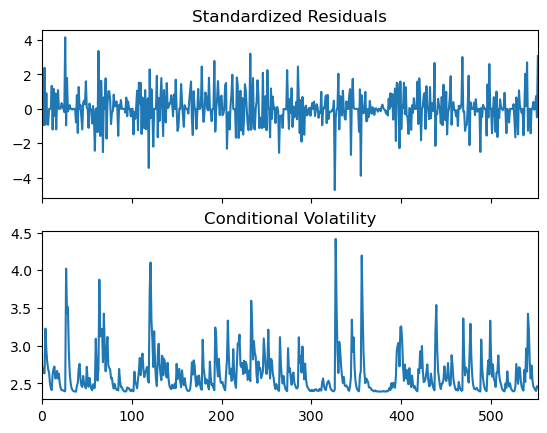

In [82]:
## multiply the log_returns by 10000 to avoid convergence warnings 
## are likely to occur in the case of very small numbers

#temp_df = book_wap_log_returns_df.iloc[:574] # selec the first time_id of stock 1

print(temp_df['log_return_10000'].std())

# plot_acf(temp_df['log_return_10000'])
# plot_pacf(temp_df['log_return_10000'])


continuous_time_id = np.arange(0, temp_df.index[-1],1) # create continuous time_id for missing time_ids
temp_df = temp_df.reindex(continuous_time_id).ffill().bfill() 

model = arch_model(temp_df['log_return_10000'], mean="Zero", vol="GARCH", p=1, q=1)


fitted_model = model.fit(disp="off")

fitted_model.plot()
fitted_model.summary()
# bic_egarch = [] # grid-search best parameters for EGARCH model
# for p in range(1, 3):
#     for q in range(0, 3):
#         egarch = arch_model(temp_df['log_return_10000'], mean='AR',vol='GARCH',p=p, q=q).fit(disp='off')
#         bic_egarch.append(egarch.bic)
#         if egarch.bic == np.min(bic_egarch):
#             best_param = p, q
#             egarch = arch_model(temp_df['log_return_10000'], mean='AR', vol='GARCH', p=p,q=q).fit(disp='off')

# temp_df['log_return_10000'][560:].plot()
# forecast = egarch.forecast(horizon=2,start=temp_df.index[-10],method="analytical",reindex=False)
# forecast.variance.plot(title="Simulation forecasts for different horizons")



In [ ]:
"""
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
"""
# ## 7a) Check if minimum/maximum of bidsize1 and asksize1 in a time_id correlated with target realized volatitlity for the same time_id?

# # @jit(nopython=True)
# # def numba_correlations_df7a_e():
# columns = ['min_bid_price', 'max_bid_price', 'min_ask_price', 'max_ask_price','min_bid_size', 'max_bid_sizee', 'min_ask_size', 'max_ask_size', 'range_ask_price', 'range_bid_price', 'range_ask_size', 'range_bid_size']
# index = unique_stocks_id
# correlations_df7a_e = pd.DataFrame(columns=columns, index=index)
# correlations_df7a_e

# for st_id in unique_stocks_id:
#     # if st_id != 0: # select the stock to display here
#     #     break
#     st_min_bid_price = []
#     st_max_bid_price = []
#     st_min_ask_price = []
#     st_max_ask_price = []
#     st_range_ask_price = []
#     st_range_bid_price = []
#     st_range_ask_size = []
#     st_range_bid_size = []
#     book_train = pd.read_parquet(file+'.parquet/stock_id='+str(st_id)) #book_train or trade_train

#     for time_id in book_train['time_id'].unique():
#         min_bid_price = book_train[book_train['time_id'] == time_id][bid_price].min()
#         st_min_bid_price.append(min_bid_price)
#         max_bid_price = book_train[book_train['time_id'] == time_id][bid_price].max()
#         st_max_bid_price.append(max_bid_price)
#         min_ask_price = book_train[book_train['time_id'] == time_id][ask_price].min()
#         st_min_ask_price.append(min_ask_price)
#         max_ask_price = book_train[book_train['time_id'] == time_id][ask_price].max()
#         st_max_ask_price.append(max_ask_price)
#         st_range_ask_price.append(max_ask_price - min_ask_price)
#         st_range_bid_price.append(max_bid_price - min_bid_price)
#         min_ask_size = book_train[book_train['time_id'] == time_id][ask_size].min()
#         max_ask_size = book_train[book_train['time_id'] == time_id][ask_size].max()
#         st_range_ask_size.append(max_ask_size - min_ask_size)
#         min_bid_size = book_train[book_train['time_id'] == time_id][bid_size].min()
#         max_bid_size = book_train[book_train['time_id'] == time_id][bid_size].max()
#         st_range_bid_size.append(max_bid_size - min_bid_size)

#     correlations_df7a_e.loc[st_id,'min_bid_price'] = pd.Series(st_min_bid_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'max_bid_price'] = pd.Series(st_max_bid_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'min_ask_price'] = pd.Series(st_min_ask_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'max_ask_price'] = pd.Series(st_max_ask_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'range_ask_price'] = pd.Series(st_range_ask_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'range_bid_price'] = pd.Series(st_range_bid_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'range_ask_size'] = pd.Series(st_range_ask_size).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7a_e.loc[st_id,'range_bid_size'] = pd.Series(st_range_bid_size).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
        
# #     return correlations_df7a_e
# # correlations_df7a_e = numba_correlations_df7a_e()
# correlations_df7a_e.to_csv('correlations_df7a_e_'+file+'_lvl_'+level+'.csv')

'\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\n'

In [ ]:
"""
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
VERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS
"""
# # @numba.jit(nopython=True)
# # def numba_sad(train:pd.DataFrame, unique_stocks_id, corr_method):
# columns = ['sad_ask_price', 'sad_ask_size', 'sad_bid_price', 'sad_bid_size']
# index = unique_stocks_id
# correlations_df7f = pd.DataFrame(columns=columns, index=index)
# correlations_df7f

# for st_id in unique_stocks_id:
#     # if st_id != 0: # select the stock to display here
#     #     break
#     st_sum_abs_dif_ask_price = []
#     st_sum_abs_dif_ask_size = []
#     st_sum_abs_dif_bid_price = []
#     st_sum_abs_dif_bid_size = []
#     book_train = pd.read_parquet(file+'.parquet/stock_id='+str(st_id))  #book_train or trade_train
    
#     for time_id in book_train['time_id'].unique():
#         sum_abs_dif_ask_price = book_train[book_train['time_id']==time_id][ask_price].diff().abs().sum() # 7f) check if the sum of absolute differences is correlated with target
#         st_sum_abs_dif_ask_price.append(sum_abs_dif_ask_price)
#         sum_abs_dif_ask_size = book_train[book_train['time_id']==time_id][ask_size].diff().abs().sum() # 7f) check if the sum of absolute differences is correlated with target
#         st_sum_abs_dif_ask_size.append(sum_abs_dif_ask_size)
#         sum_abs_dif_bid_price = book_train[book_train['time_id']==time_id][bid_price].diff().abs().sum() # 7f) check if the sum of absolute differences is correlated with target
#         st_sum_abs_dif_bid_price.append(sum_abs_dif_bid_price)
#         sum_abs_dif_bid_size = book_train[book_train['time_id']==time_id][bid_size].diff().abs().sum()
#         st_sum_abs_dif_bid_size.append(sum_abs_dif_bid_size)

#     correlations_df7f.loc[st_id,'sad_ask_price'] = pd.Series(st_sum_abs_dif_ask_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7f.loc[st_id,'sad_ask_size'] = pd.Series(st_sum_abs_dif_ask_size).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)
#     correlations_df7f.loc[st_id,'sad_bid_price'] = pd.Series(st_sum_abs_dif_bid_price).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method) 
#     correlations_df7f.loc[st_id,'sad_bid_size'] = pd.Series(st_sum_abs_dif_bid_size).corr(pd.Series(train[train['stock_id'] == st_id]['target']),method=corr_method)

# #     return correlations_df7f
# # correlations_df7f = numba_sad(train=train, unique_stocks_id=unique_stocks_id, corr_method=corr_method)
# correlations_df7f.to_csv('correlations_df7f_'+file+'_lvl_'+level+'.csv')

'\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\nVERY SLOW CODE BELOW BECAUSE OF NESTED FOR LOOPS\n'

In [ ]:
# ## single stock book data 
# ## check how prices are distributed in the book data so that we can see how log(s_t2/s_t1) transformation of prices below and above 1 affects volatitliy.
""" ## THE RESULTS ARE ALREADY DOCUMENTED IN IDEAS """
# st_min_bid_price = []
# st_max_bid_price = []
# st_min_ask_price = []
# st_max_ask_price = []

# for st_id in unique_stocks_id:

#     book_train = pd.read_parquet('book_train.parquet/stock_id='+str(st_id))
#     st_min_bid_price.append(book_train["bid_price1"].min())
#     st_max_bid_price.append(book_train["bid_price1"].max())
#     st_min_ask_price.append(book_train["ask_price1"].min())
#     st_max_ask_price.append(book_train["ask_price1"].max())
#     if st_id != 1: # selec the stock to display here
#         continue
#     select_id = st_id
#     print(book_train["bid_price1"].max())
#     print(book_train["bid_price1"].min())

# all_st_min_ask_price = np.min(np.array(st_min_ask_price))
# all_st_max_ask_price = np.min(np.array(st_max_ask_price))
# all_st_min_bid_price = np.min(np.array(st_min_bid_price))
# all_st_max_bid_price = np.min(np.array(st_max_bid_price))

# print(f'min ask price in all stocks: {all_st_min_ask_price}')
# print(f'max ask price in all stocks: {all_st_max_ask_price}')
# print(f'min bid price in all stocks: {all_st_min_bid_price}')
# print(f'max bid price in all stocks: {all_st_max_bid_price}')


# print('stock id '+str(select_id))
# book_train

' ## THE RESULTS ARE ALREADY DOCUMENTED IN IDEAS '

In [ ]:
# ## due to log nature check if non-linearity is visible
# ## Non-linearity is NOT visible as variance in price is low. so NO need to treat prices < 1 differently from prices > 1.
""" ## THE RESULTS ARE ALREADY DOCUMENTED IN IDEAS """
# plt.figure()
# plt.plot(np.arange(all_st_min_bid_price,all_st_max_bid_price,0.0001),np.log(np.arange(all_st_min_bid_price,all_st_max_bid_price,0.0001)),)
# plt.title("log of all_st_min_bid_price to all_st_max_bid_price")
# plt.grid()
# plt.show()

# plt.figure()
# plt.plot(np.arange(all_st_min_ask_price,all_st_max_ask_price,0.0001),np.log(np.arange(all_st_min_ask_price,all_st_max_ask_price,0.0001)),)
# plt.title("log of all_st_min_ask_price to all_st_max_ask_price")
# plt.grid()
# plt.show()

' ## THE RESULTS ARE ALREADY DOCUMENTED IN IDEAS '